# Chapter 5 - Exercises

## Set Up

### Packages

In [1]:
import os

import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.interpolate import BSpline
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
LDS_FILE = "lds_by_state.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## Easy

### 5E1

Which of the linear models below are multiple linear regressions?
1. $\mu_i = \alpha + \beta x_i$
2. $\mu_i = \beta_x x_i + \beta_z z_i$
3. $\mu_i = \alpha + \beta (x_i - z_i)$
4. $\mu_i = \alpha + \beta_x x_i + \beta_z z_i$

---

2 and 4.

### 5E2

Write down a multiple regression to evaluate the claim: Animal diversity is linearly related to latitude, but only after controlling for plant diversity.
You just need to write down the model definition.

---

Let `A`, `L`, and `P` denote animal diversity, latitute, and plant diversity, respectively. Then the model is

\begin{align}
    A_i & \sim \text{Normal}(\mu_i, \sigma) \\
    \mu_i & = \alpha + \beta_L L_i + \beta_P P_i.
\end{align}

### 5E3

Write down a multiple regression to evaluate the claim: Neither amount of funding nor size of laboratory is by itself a good predictor of time to PhD degree; but together these variables are both positively associated with time to degree.
Write down the model definition and indicate which side of zero each slope parameter should be on.

---

Let `T`, `F`, and `L` denote time to PhD, amount of funding, and size of laboratory, respectively. Then the model is

\begin{align}
    T_i & \sim \text{Normal}(\mu_i, \sigma) \\
    \mu_i & = \alpha + \beta_F F_i + \beta_L L_i.
\end{align}

If together both are positively associated with time to degree then both $\beta_F$ and $\beta_L$ should be positive.
If neither is a good predictor on its own then I expect that they are negatively associated with each other; that is, larger laboratories have less funding per student.

### 5E4

Suppose you have a single categorical predictor with 4 levels (unique values), labeled A, B, C and D.
Let $A_i$ be an indicator variable that is 1 where case $i$ is in category A. Also suppose $B_i$, $C_i$, and $D_i$ for the other categories.
Now which of the following linear models are inferentially equivalent ways to include the categorical variable in a regression?
Models are inferentially equivalent when it’s possible to compute one posterior distribution from the posterior distribution of another model.
1. $\mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_D D_i$
2. $\mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_C C_i + \beta_D D_i$
3. $\mu_i = \alpha + \beta_B B_i + \beta_C C_i + \beta_D D_i$
4. $\mu_i = \alpha_A A_i + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i$
5. $\mu_i = \alpha_A (1 - B_i - C_i - D_i) + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i$

---

All the models except (2) are inferrentially equivalent: since each case must belong to one of the categories, $A_i + B_i + C_i + D_i = 1$, and so any models that contain exactly four out of $A_i$, $B_i$, $C_i$, $D_i$, and a constant term are inferentially equivalent.
It is possible to compute the posterior distribution of any of the models from that of (2), but not the other way round.
To illustrate this suppose that we $alpha \sim \text{Uniform}(0, 1)$ and $\alpha = \beta + \gamma$.
It is possible that $\beta \sim \text{Uniform}(0, x)$ and $\gamma \sim \text{Uniform}(x, 1)$ for any $x \in  (0, 1)$, so the distributions of $\beta$ and $\gamma$ are not uniquely determined by that of $\alpha$.

## Medium

### 5M1

Invent your own example of a spurious correlation.
An outcome variable should be correlated with both predictor variables.
But when both predictors are entered in the same model, the correlation between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

---

Generate sample data

In [5]:
def add_noise(x, size, scale):
    return x + +stats.norm.rvs(loc=0, scale=scale, size=size)

In [6]:
n_samples = 100

x1 = np.linspace(-2, 2, n_samples)
x1 = add_noise(x1, n_samples, 0.5)

x2 = 2 * x1 - 1
x2 = add_noise(x2, n_samples, 0.5)

y = 0.5 * x1 + 1
y = add_noise(y, n_samples, 0.5)

data = pd.DataFrame(
    {
        "x1": x1,
        "x2": x2,
        "y": y,
    }
)

First model the outcome as a linear function of the individual predictors

In [7]:
with pm.Model() as m_5m1a:
    # data
    x1 = pm.MutableData("x1", data.x1, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta1 = pm.Normal("beta1", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # linear model
    mu = pm.Deterministic("mu", alpha + beta1 * x1, dims="obs")

    # likelihood
    y_pm = pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs")

    # sample
    trace_5m1a = pm.sample(random_seed=RANDOM_SEED)


with pm.Model() as m_5m1b:
    # data
    x2 = pm.MutableData("x2", data.x2, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta2 = pm.Normal("beta2", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # linear model
    mu = pm.Deterministic("mu", alpha + beta2 * x2, dims="obs")

    # likelihood
    y_pm = pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs")

    # sample
    trace_5m1b = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Plot the posterior predictions

In [8]:
def plot_posterior_lines(trace, predictor, hdi_prob=0.89, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 4))

    # plot data
    sns.scatterplot(
        x=trace.constant_data[predictor],
        y=trace.observed_data.y,
        ax=ax,
    )

    # plot mean line
    ax.plot(
        trace.constant_data[predictor],
        trace.posterior.mu.mean(dim=["chain", "draw"]),
        color="k",
    )

    # plot HDI on mu
    mu_hdi = az.hdi(trace.posterior.mu, hdi_prob=hdi_prob)
    mu_hdi = pd.DataFrame(
        {
            predictor: trace.constant_data[predictor],
            "lower": mu_hdi.mu.sel(hdi="lower"),
            "higher": mu_hdi.mu.sel(hdi="higher"),
        }
    ).sort_values(predictor)

    ax.fill_between(
        mu_hdi[predictor],
        mu_hdi["lower"],
        mu_hdi["higher"],
        color="k",
        alpha=0.3,
    )

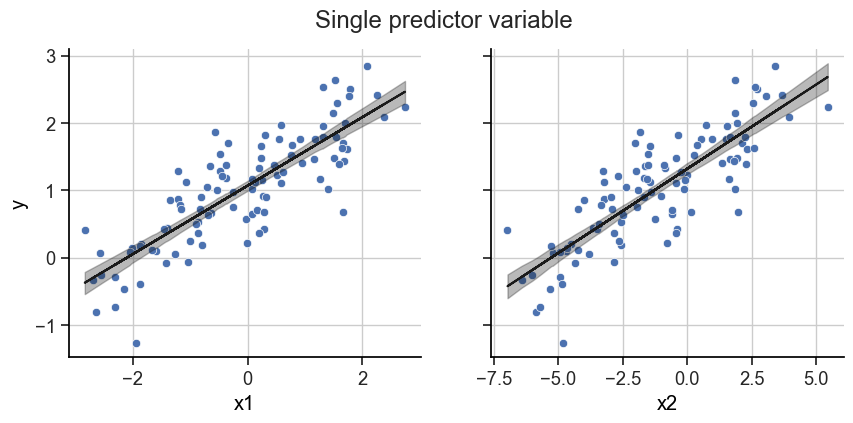

In [9]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))

plot_posterior_lines(trace_5m1a, "x1", ax=axs[0])
plot_posterior_lines(trace_5m1b, "x2", ax=axs[1])

fig.suptitle("Single predictor variable");

There are very clear associations.

Now generate a multiple linear model

In [10]:
with pm.Model() as m_5m1c:
    # data
    x1 = pm.MutableData("x1", data.x1, dims="obs")
    x2 = pm.MutableData("x2", data.x2, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta1 = pm.Normal("beta1", mu=0, sigma=2)
    beta2 = pm.Normal("beta2", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # linear model
    mu = pm.Deterministic("mu", alpha + beta1 * x1 + beta2 * x2, dims="obs")

    # likelihood
    y_pm = pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs")

    # sample
    trace_5m1c = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


The easiest thing to do it to compare the posterior distributions for the $\beta$:

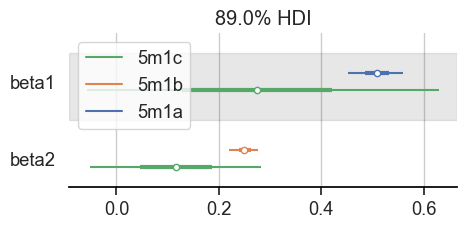

In [11]:
pm.plot_forest(
    [trace_5m1a, trace_5m1b, trace_5m1c],
    model_names=["5m1a", "5m1b", "5m1c"],
    var_names=["beta"],
    filter_vars="regex",
    combined=True,
    hdi_prob=0.89,
    figsize=(5, 2),
);

You can see that $\beta_2$ becomes centered at 0 once we include $x_1$ in the model.

We can also plot what happens in the multivariable model if we hold one variable constant and vary the other.

In [12]:
def plot_predictions_holding_other_variables_constant(
    model, trace, predictor, n_samples=100, hdi_prob=0.89, ax=None
):
    with model:
        predictor_min = trace.constant_data[predictor].min().item()
        predictor_max = trace.constant_data[predictor].max().item()

        all_variables = list(trace_5m1c.constant_data.data_vars.keys())
        new_data = pd.DataFrame(columns=all_variables)
        new_data[predictor] = np.linspace(
            predictor_min, predictor_max, n_samples  # - 0.25,  # + 0.25,
        )
        new_data = new_data.fillna(0)

        pm.set_data({var: new_data[var] for var in all_variables})
        pp_trace = pm.sample_posterior_predictive(
            trace,
            var_names=["mu", "y"],
            predictions=True,
            random_seed=RANDOM_SEED,
        )

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 4))

    # plot mean line
    ax.plot(
        pp_trace.predictions_constant_data[predictor],
        pp_trace.predictions.mu.mean(dim=["chain", "draw"]),
        color="k",
    )

    # plot HDI on mu
    mu_hdi = az.hdi(pp_trace.predictions.mu, hdi_prob=hdi_prob)
    mu_hdi = pd.DataFrame(
        {
            predictor: pp_trace.predictions_constant_data[predictor],
            "lower": mu_hdi.mu.sel(hdi="lower"),
            "higher": mu_hdi.mu.sel(hdi="higher"),
        }
    ).sort_values(predictor)

    ax.fill_between(
        mu_hdi[predictor],
        mu_hdi["lower"],
        mu_hdi["higher"],
        color="k",
        alpha=0.3,
    )

    ax.set(
        xlabel=predictor,
        ylabel="y",
    )

Let's plot all of this together

Sampling: [y]


Sampling: [y]


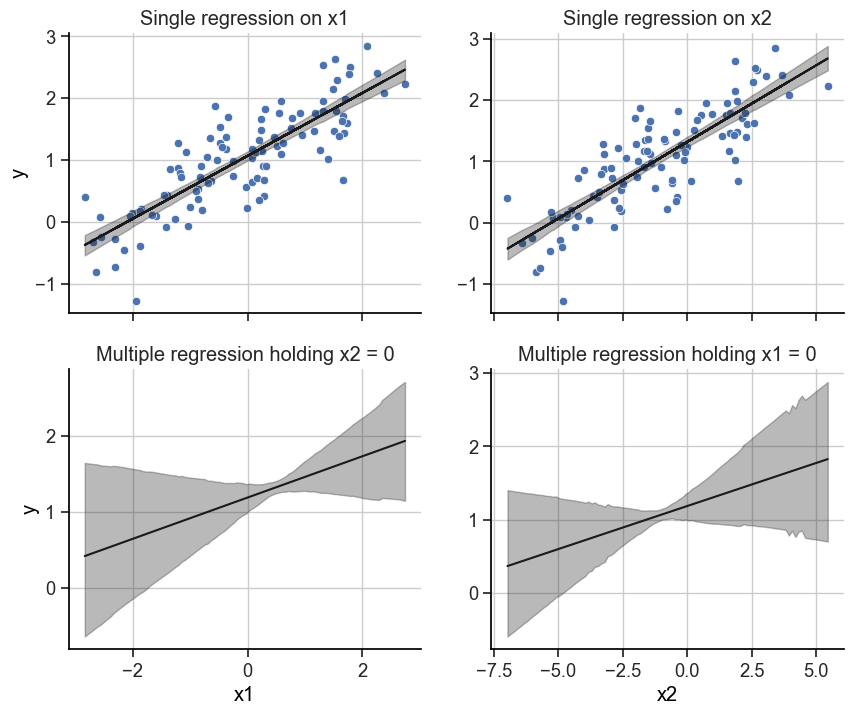

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# first plot the single predictor models
plot_posterior_lines(trace_5m1a, "x1", ax=axs[0, 0])
axs[0, 0].set(xlabel=None, title="Single regression on x1")
axs[0, 0].tick_params(labelbottom=False)

plot_posterior_lines(trace_5m1b, "x2", ax=axs[0, 1])
axs[0, 1].set(xlabel=None, ylabel=None, title="Single regression on x2")
axs[0, 1].tick_params(labelbottom=False)

# now the multiple regression model
plot_predictions_holding_other_variables_constant(
    m_5m1c, trace_5m1c, "x1", ax=axs[1, 0]
)
axs[1, 0].set(title="Multiple regression holding x2 = 0")

plot_predictions_holding_other_variables_constant(
    m_5m1c, trace_5m1c, "x2", ax=axs[1, 1]
)
axs[1, 1].set(ylabel=None, title="Multiple regression holding x1 = 0");

### 5M2

Invent your own example of a masked relationship.
An outcome variable should be correlated with both predictor variables, but in opposite directions.
And the two predictor variables should be correlated with one another.

---

This is pretty similar to the previous example so I'll skip most of the plots.

In [14]:
def add_noise(x, size, scale):
    return x + +stats.norm.rvs(loc=0, scale=scale, size=size)

In [15]:
n_samples = 100

x1 = np.linspace(-2, 2, n_samples)
x1 = add_noise(x1, n_samples, 0.5)

x2 = np.linspace(-4, 4, n_samples)
x2 = add_noise(x2, n_samples, 0.5)

y = 2 * x1 - x2 + 1
y = add_noise(y, n_samples, 0.1)

data = pd.DataFrame(
    {
        "x1": x1,
        "x2": x2,
        "y": y,
    }
)

In [16]:
with pm.Model() as m_5m2a:
    # data
    x1 = pm.MutableData("x1", data.x1, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta1 = pm.Normal("beta1", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # linear model
    mu = pm.Deterministic("mu", alpha + beta1 * x1, dims="obs")

    # likelihood
    y_pm = pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs")

    # sample
    trace_5m2a = pm.sample(random_seed=RANDOM_SEED)


with pm.Model() as m_5m2b:
    # data
    x2 = pm.MutableData("x2", data.x2, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta2 = pm.Normal("beta2", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # linear model
    mu = pm.Deterministic("mu", alpha + beta2 * x2, dims="obs")

    # likelihood
    y_pm = pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs")

    # sample
    trace_5m2b = pm.sample(random_seed=RANDOM_SEED)


with pm.Model() as m_5m2c:
    # data
    x1 = pm.MutableData("x1", data.x1, dims="obs")
    x2 = pm.MutableData("x2", data.x2, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta1 = pm.Normal("beta1", mu=0, sigma=2)
    beta2 = pm.Normal("beta2", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # linear model
    mu = pm.Deterministic("mu", alpha + beta1 * x1 + beta2 * x2, dims="obs")

    # likelihood
    y_pm = pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs")

    # sample
    trace_5m2c = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


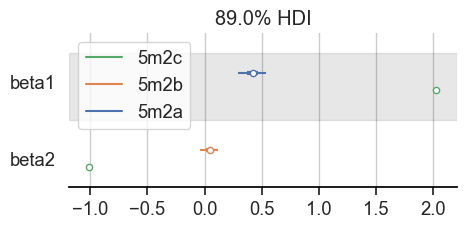

In [17]:
pm.plot_forest(
    [trace_5m2a, trace_5m2b, trace_5m2c],
    model_names=["5m2a", "5m2b", "5m2c"],
    var_names=["beta"],
    filter_vars="regex",
    combined=True,
    hdi_prob=0.89,
    figsize=(5, 2),
);

The coefficients in the single regressions are very close to zero, but in the multiple regression they are significantly non-zero.

### 5M3

It is sometimes observed that the best predictor of fire risk is the presence of firefighters—States and localities with many firefighters also have more fires.
Presumably firefighters do not cause fires.
Nevertheless, this is not a spurious correlation.
Instead fires cause firefighters.
Consider the same reversal of causal inference in the context of the divorce and marriage data.
How might a high divorce rate cause a higher marriage rate?
Can you think of a way to evaluate this relationship, using multiple regression?

---

People who are currently married can't get married again, so having a high divorce rate could cause a higher marriage rate.
For example, in a state in which many people get divorced, the average number of marriages per person may be above one, which wouldn't be possible in a state with very few divorces.

Recall that our current model is $D \leftarrow A \rightarrow M$ since we concluded that $D$ and $M$ were conditionally independent given $A$.
To evaluate the effect of $D$ on $M$ we could make $M$ our outcome variable and model it using regression on $A$ and $D$.

### 5M4

In the divorce data, States with high numbers of members of the Church of Jesus Christ of Latter-day Saints (LDS) have much lower divorce rates than the regression models expected.
Find a list of LDS population by State and use those numbers as a predictor variable, predicting divorce rate using marriage rate, median age at marriage, and percent LDS population (possibly standardized).
You may want to consider transformations of the raw percent LDS variable.

---

#### Data preparation

We pull data from WorldAtlas from 2020 ([source](https://www.worldatlas.com/articles/mormon-population-by-state.html)).

In [18]:
lds = load_data(LDS_FILE, index_col=0)
waffle = load_data(WAFFLE_DIVORCE_FILE, delimiter=";")

# merge the two
waffle_lds = waffle.merge(
    lds,
    how="outer",
    left_on="Location",
    right_on="State",
    validate="one_to_one",
)

Let's take a look at the data

In [19]:
waffle_lds[["Location", "Population", "State", "Total State Population"]]

,Location,Population,State,Total State Population
0,Alabama,4.78,Alabama,4863300
1,Alaska,0.71,Alaska,741894
2,Arizona,6.33,Arizona,6931071
3,Arkansas,2.92,Arkansas,2988248
4,California,37.25,California,39250017
5,Colorado,5.03,Colorado,5540545
6,Connecticut,3.57,Connecticut,3576452
7,Delaware,0.90,Delaware,952065
8,District of Columbia,0.60,District of Columbia,681170
9,Florida,18.80,Florida,20612439


The `waffle` data is missing a row for Nevada and the `lds` population figures are slightly larger (the data is probably more recent), but not enough to matter too much.
We'll drop Nevada.

In [20]:
waffle_lds = waffle_lds.dropna(subset=["Location"])

Let's take a closer look at the 'Proportion of Mormon Residents' data:

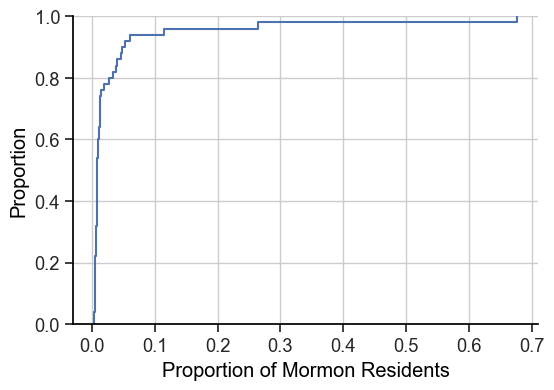

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.ecdfplot(waffle_lds, x="Proportion of Mormon Residents", ax=ax);

This distribution is wild because Utah (and Idaho) have much higher proportion of LDS members.
To make this more tractable we'll take the log of this variable.

In [22]:
waffle_lds["Log Proportion of Mormon Residents"] = np.log(
    waffle_lds["Proportion of Mormon Residents"]
)

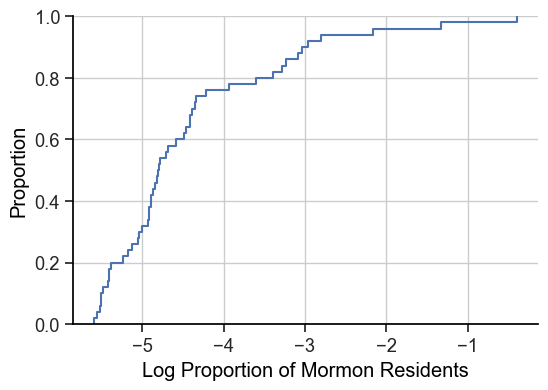

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.ecdfplot(waffle_lds, x="Log Proportion of Mormon Residents", ax=ax);

This looks much more reasonable.
Finally let's standardise the variables.

In [24]:
# standardise variables
waffle_lds_normaliser = StandardScaler()
waffle_lds[
    ["divorce", "marriage", "age", "log_prop_lds"]
] = waffle_lds_normaliser.fit_transform(
    waffle_lds[
        [
            "Divorce",
            "Marriage",
            "MedianAgeMarriage",
            "Log Proportion of Mormon Residents",
        ]
    ]
)

#### Modelling

Begin by redefining the original model without the LDS variable

In [25]:
with pm.Model() as m5_3:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_age = pm.Normal("beta_age", mu=0, sigma=0.5)
    beta_marriage = pm.Normal("beta_marriage", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # data
    age = pm.MutableData("age", waffle_lds.age, dims="state")
    marriage = pm.MutableData("marriage", waffle_lds.marriage, dims="state")
    log_prop_lds = pm.MutableData("log_prop_lds", waffle_lds.log_prop_lds, dims="state")

    # linear model
    mu = pm.Deterministic(
        "mu", alpha + beta_age * age + beta_marriage * marriage, dims="state"
    )

    # likelihood
    divorce = pm.Normal(
        "divorce", mu=mu, sigma=sigma, observed=waffle_lds.divorce, dims="state"
    )

    # sample
    trace_5_3 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_marriage, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Let's plot the residuals against the log proportion of LDS

In [26]:
def plot_posterior_residuals_against_log_prop_lds(trace, hdi_prob=0.89, ax=None):
    # add the residual
    trace.posterior["residual"] = trace.observed_data.divorce - trace.posterior.mu

    if not ax:
        fig, ax = plt.subplots(figsize=(5, 4))

    # plot residuals against log prop lds
    sns.scatterplot(
        x=trace.constant_data.log_prop_lds,
        y=trace.posterior.residual.mean(dim=["chain", "draw"]),
        ax=ax,
    )

    # plot HDI
    residuals_hdi = az.hdi(trace.posterior.residual, hdi_prob=hdi_prob)
    ax.plot(
        [
            trace.constant_data.log_prop_lds,
            trace.constant_data.log_prop_lds,
        ],
        residuals_hdi.residual.T,
        color=colors[0],
        lw=0.8,
    )

    ax.set(
        xlabel="Log proportion LDS",
        ylabel="Residual",
        title="Posterior residuals against log prop LDS",
    )

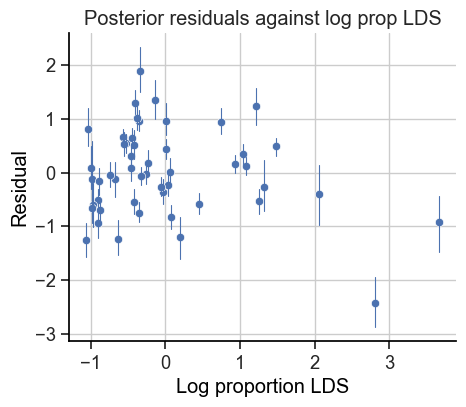

In [27]:
plot_posterior_residuals_against_log_prop_lds(trace_5_3)

It's clear that the two points to the furthest right (Idaha and Utah) are underpredicted but harder to see if there's a general trend.

Let's recreate the model with the additional predictor.

In [28]:
with pm.Model() as m_5m4:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_age = pm.Normal("beta_age", mu=0, sigma=0.5)
    beta_marriage = pm.Normal("beta_marriage", mu=0, sigma=0.5)
    beta_log_prop_lds = pm.Normal("beta_log_prop_lds", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # data
    age = pm.MutableData("age", waffle_lds.age, dims="state")
    marriage = pm.MutableData("marriage", waffle_lds.marriage, dims="state")
    log_prop_lds = pm.MutableData("log_prop_lds", waffle_lds.log_prop_lds, dims="state")

    # linear model
    mu = pm.Deterministic(
        "mu",
        alpha
        + beta_age * age
        + beta_marriage * marriage
        + beta_log_prop_lds * log_prop_lds,
        dims="state",
    )

    # likelihood
    divorce = pm.Normal(
        "divorce", mu=mu, sigma=sigma, observed=waffle_lds.divorce, dims="state"
    )

    # sample
    trace_5m4 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_marriage, beta_log_prop_lds, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Let's compare the posteriors

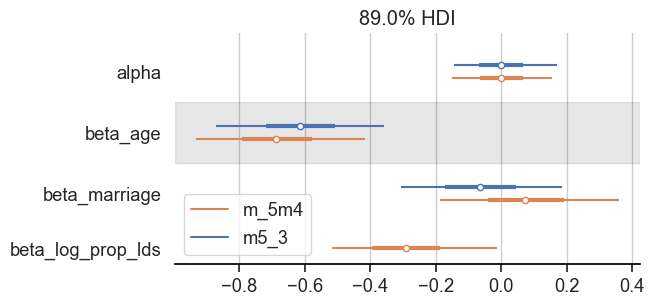

In [29]:
az.plot_forest(
    [trace_5_3, trace_5m4],
    model_names=["m5_3", "m_5m4"],
    var_names=["alpha", "beta"],
    filter_vars="regex",
    hdi_prob=0.89,
    combined=True,
    figsize=(6, 3),
);

The log proportion of LDS in each state does seem to have a non-zero weight which implies that it adds extra explanatory power on top of the existing variables.

Let's compare the posterior predictions for each state.

In [30]:
def plot_divorce_posterior_predictions(trace, hdi_prob=0.89, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 5))

    # predicted against observed
    sns.scatterplot(
        x=trace.observed_data.divorce,
        y=trace.posterior.mu.mean(dim=["chain", "draw"]),
        facecolors="none",
        edgecolor=colors[0],
        ax=ax,
    )

    # add hdi
    mu_hdi = az.hdi(trace.posterior.mu, hdi_prob=hdi_prob)
    ax.plot(
        [
            trace.observed_data.divorce,
            trace.observed_data.divorce,
        ],
        mu_hdi.mu.T,
        color=colors[0],
        lw=0.8,
    )

    # true value line
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    diag_line_vals = np.linspace(
        np.array(xlim[0], ylim[0]).max(),
        np.array(xlim[1], ylim[1]).min(),
        100,
    )
    ax.plot(
        diag_line_vals,
        diag_line_vals,
        ls="--",
        color="k",
    )

    ax.set(
        xlabel="Observed divorce",
        ylabel="Predicted divorce",
        title="Posterior prediction plot",
    )

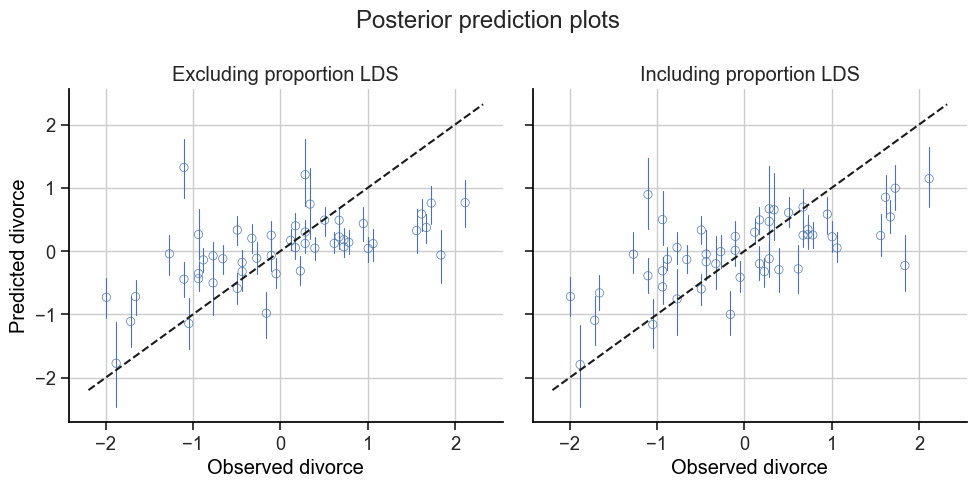

In [31]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

plot_divorce_posterior_predictions(trace_5_3, ax=axs[0])
plot_divorce_posterior_predictions(trace_5m4, ax=axs[1])

axs[0].set_title("Excluding proportion LDS")
axs[1].set_title("Including proportion LDS")

fig.suptitle("Posterior prediction plots")
fig.tight_layout();

Let's recreate the earlier plot but with this new model.

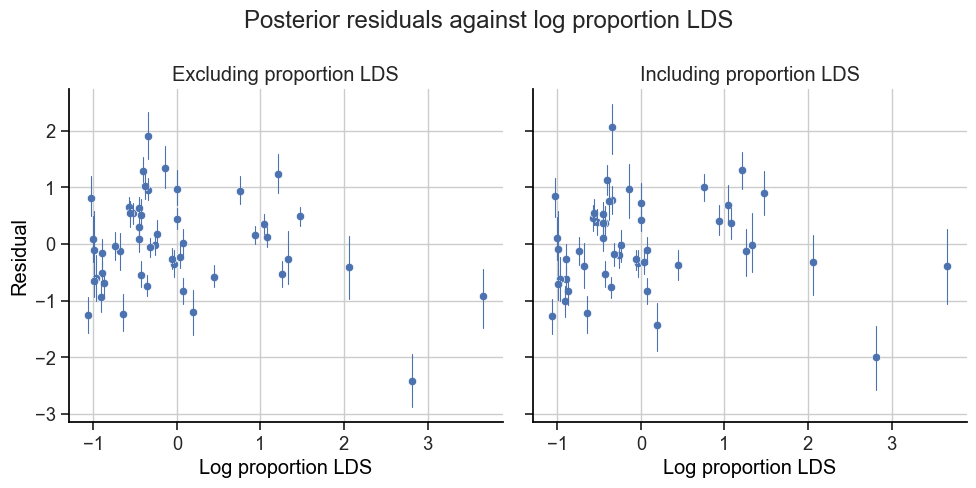

In [32]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

plot_posterior_residuals_against_log_prop_lds(trace_5_3, ax=axs[0])
plot_posterior_residuals_against_log_prop_lds(trace_5m4, ax=axs[1])

axs[0].set_title("Excluding proportion LDS")
axs[1].set_title("Including proportion LDS")

fig.suptitle("Posterior residuals against log proportion LDS")
fig.tight_layout();

### 5M5

One way to reason through multiple causation hypotheses is to imagine detailed mechanisms through which predictor variables may influence outcomes.
For example, it is sometimes argued that the price of gasoline (predictor variable) is positively associated with lower obesity rates (outcome variable).
However, there are at least two important mechanisms by which the price of gas could reduce obesity.
First, it could lead to less driving and therefore more exercise.
Second, it could lead to less driving, which leads to less eating out, which leads to less consumption of huge restaurant meals.
Can you outline one or more multiple regressions that address these two mechanisms?
Assume you can have any predictor data you need.

---

Let $G$, $D$, $E$, and $O$ denote gas price, amount of driving, level of eating out, and obesity respectively.
The overall relationship of interest is $G \to O$.

The first mechanism argues for a causal influence $G \to D \to O$.
We could address this with a multiple regression of $O$ on $G$ and $D$ and compare this with a single regression of $O$ on $G$.
The question to address is whether $D$ adds any explanatory power with $G$ also in the model.

The second mechanism argues for a causal influence $D \to E \to O$.
Again, this can be analysis by regressing $O$ on $D$ and $E$ and comparing with a regression of $O$ on $D$.

## Hard

### 5H1

In the divorce example, suppose the DAG is: $M \to A \to D$.
What are the implied conditional independencies of the graph?
Are the data consistent with it?

---

Since there is no direct arrow from $M$ to $D$, this implies that $D$ is conditionally independent of $M$, given $A$.

The data are consistent with this DAG; in a multiple regression of $D$ on $A$ and $M$, there is little predictive power in $M$.
This is consistent with the claim that $D$ is conditionally independent of $M$ given $A$.

### 5H2

Assuming that the DAG for the divorce example is indeed $M \to A \to D$, fit a new model and use it to estimate the counterfactual effect of halving a State’s marriage rate $M$.
Using the counterfactual example from the chapter (starting on page 140) as a template.

---

Since there is no direct causal arrow from $M$ to $D$, all we need to do is to model $A$ as a linear function of $M$, and $D$ as a function of $D$.

In [33]:
# load data
waffle = load_data(WAFFLE_DIVORCE_FILE, delimiter=";")

# standardise variables
waffle_normaliser = StandardScaler().set_output(transform="pandas")
waffle[["divorce", "marriage", "age"]] = waffle_normaliser.fit_transform(
    waffle[["Divorce", "Marriage", "MedianAgeMarriage"]]
)

Define the models

In [34]:
coords = {
    "state": waffle.Location,
    "outcome": ["age", "divorce"],
}
with pm.Model(coords=coords) as m_5h2:
    # data
    marriage = pm.MutableData("marriage", waffle.marriage, dims="state")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2, dims="outcome")
    beta = pm.Normal("beta", mu=0, sigma=0.5, dims="outcome")
    sigma = pm.Exponential("sigma", lam=1, dims="outcome")

    # mu model
    mu_age = pm.Deterministic("mu_age", alpha[0] + beta[0] * marriage, dims="state")
    age = pm.Normal("age", mu=mu_age, sigma=sigma[0], observed=waffle.age, dims="state")

    # divorce model
    mu_divorce = pm.Deterministic("mu_divorce", alpha[1] + beta[1] * age, dims="state")
    divorce = pm.Normal(
        "divorce", mu=mu_divorce, sigma=sigma[1], observed=waffle.divorce, dims="state"
    )

    # sample prior
    trace_5h2 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


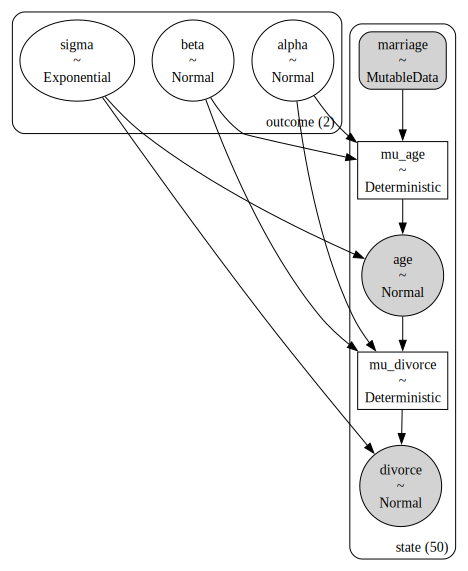

In [35]:
m_5h2.to_graphviz()

Take a look at the results.

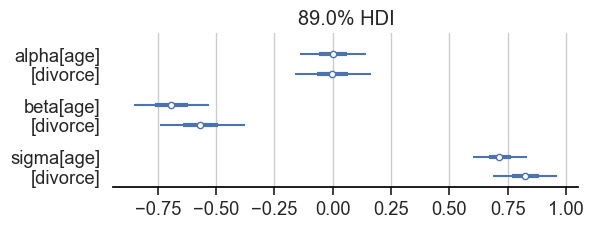

In [36]:
az.plot_forest(
    trace_5h2,
    var_names=["~mu"],
    filter_vars="regex",
    hdi_prob=0.89,
    combined=True,
    figsize=(6, 2),
);

I also want to plot the posterior predictions for each of the regressions.

In [37]:
def plot_posterior_predictions(
    predictor_data, outcome_data, posterior_data, hdi_prob=0.89, ax=None
):
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 4))

    # observed data
    sns.scatterplot(
        x=predictor_data,
        y=outcome_data,
        ax=ax,
    )

    # get data to plot posteriors
    posterior_name = posterior_data.name
    posterior_hdi = az.hdi(posterior_data, hdi_prob=hdi_prob)
    plot_data = pd.DataFrame(
        {
            "predictor": predictor_data,
            "mean": posterior_data.mean(dim=["chain", "draw"]),
            "hdi_lower": posterior_hdi[posterior_name].sel(hdi="lower"),
            "hdi_higher": posterior_hdi[posterior_name].sel(hdi="higher"),
        }
    ).sort_values("predictor")

    # posterior mean
    ax.plot(
        plot_data["predictor"],
        plot_data["mean"],
        color="k",
    )

    # posterior hdi
    ax.fill_between(
        plot_data["predictor"],
        plot_data["hdi_lower"],
        plot_data["hdi_higher"],
        color="k",
        alpha=0.3,
    )

    ax.set(title="Posterior predictions")

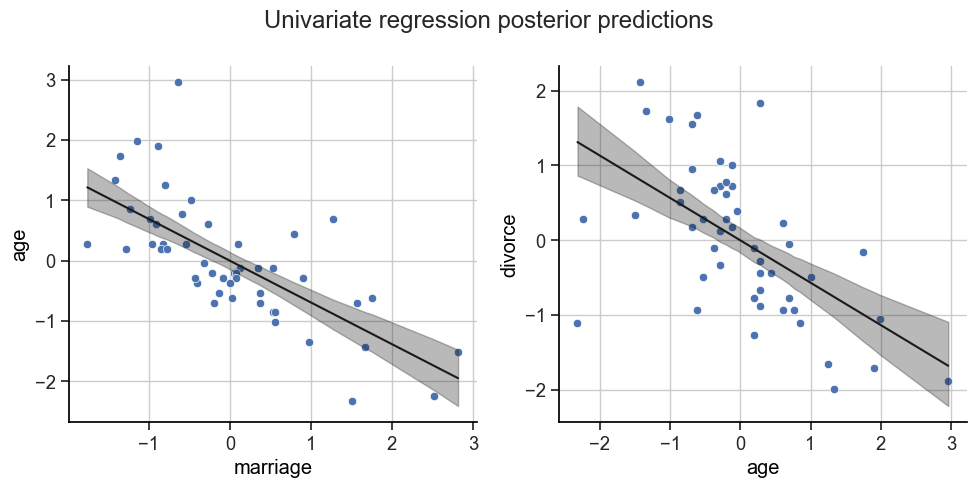

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

plot_posterior_predictions(
    trace_5h2.constant_data.marriage,
    trace_5h2.observed_data.age,
    trace_5h2.posterior.mu_age,
    ax=axs[0],
)
plot_posterior_predictions(
    trace_5h2.observed_data.age,
    trace_5h2.observed_data.divorce,
    trace_5h2.posterior.mu_divorce,
    ax=axs[1],
)

for ax in axs:
    ax.set_title(None)

fig.suptitle("Univariate regression posterior predictions")
fig.tight_layout();

We can then look at the combined model, pulling predicted values for age through to predict divorce values

In [39]:
with m_5h2:
    trace_5h2 = pm.sample_posterior_predictive(
        trace_5h2,
        var_names=["mu_age", "age", "mu_divorce", "divorce"],
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

Sampling: [age, divorce]


Plot this with HDIs for both $\mu$ and the posterior divorce predictions

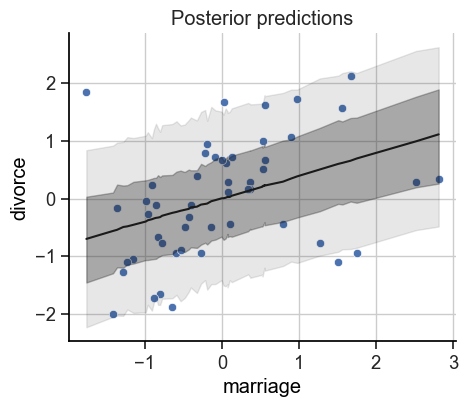

In [40]:
fig, ax = plt.subplots(figsize=(5, 4))

plot_posterior_predictions(
    trace_5h2.constant_data.marriage,
    trace_5h2.observed_data.divorce,
    trace_5h2.posterior_predictive.mu_divorce,
    ax=ax,
)

divorce_hdi = az.hdi(trace_5h2.posterior_predictive.divorce, hdi_prob=0.89)
hdi_data = pd.DataFrame(
    {
        "marriage": trace_5h2.constant_data.marriage,
        "lower": divorce_hdi.divorce.sel(hdi="lower"),
        "higher": divorce_hdi.divorce.sel(hdi="higher"),
    }
).sort_values("marriage")
ax.fill_between(
    hdi_data.marriage,
    hdi_data.lower,
    hdi_data.higher,
    color="k",
    alpha=0.1,
);

Notice that pulling this through has massively increased the uncertainty in $\mu\text{[divorce]}$.
This is partly because $\mu\text{[divorce]}$ depends on the posterior predictive values of age, not just the posterior of $\mu\text{[age]}$; that is, the posterior of $\sigma\text{[age]}$ contributes to the predictions of $\mu\text{[divorce]}$.

Now we want to estimate the effect of halving the marriage rate in a State.
To generate the counterfactual predictions we first need to normalise the half marriage values.

In [41]:
# generate half marriage rates
counterfactual_data = pd.DataFrame(columns=waffle_normaliser.feature_names_in_)
counterfactual_data["Marriage"] = waffle["Marriage"] / 2

# normalise
marriage_half = waffle_normaliser.transform(counterfactual_data).Marriage.values

Now generate the counterfactual predictions

In [42]:
with m_5h2:
    pm.set_data({"marriage": marriage_half})
    trace_5h2 = pm.sample_posterior_predictive(
        trace_5h2,
        var_names=["mu_age", "age", "mu_divorce", "divorce"],
        extend_inferencedata=True,
        predictions=True,
        random_seed=RANDOM_SEED,
    )

Sampling: [age, divorce]


Generating the counterfactual predictions requires making a decision: for a state with marriage rate $m$ and true divorce rate $d$, should we simply use the posterior predictive divorce distribution for marriage rate $\frac{m}{2}$, or should we look at the difference between the posterior predictive divorce distributions for marriage rates $m$ and $\frac{m}{2}$ and subtract this from the observed divorce rate $d$.
These actually correspond to different modelling assumptions.

The first assumes that each State's divorce rate is a random sample from the posterior predictive and if the state was resampled (with a different marriage rate) it would regress towards the mean.
This is analogous to rolling a die - if on the first roll we got a value higher than expected, we would still expect the second roll to be centred at the expected value.

The second assumes that each State has latent characteristics that explain the difference from the model and that these would remain even if the marriage rate changed.
So if a particular State's divorce rate if $x$ above the model's prediction at that marriage rate, then we would expect it to still be $x$ above the model predictions at the new marriage rate.

I think the second is a more realistic model of the situation so will use that to generate the counterfactual divorce predictions.
That is, I will look at the predicted effect on divorce rate of halving marriage rate for a given marriage rate and apply that to the specific divorce rate for the State.

First we find the effect on divorce rate of halving marriage rate.

In [43]:
trace_5h2.predictions["divorce_half_marriage_change"] = (
    trace_5h2.predictions.divorce - trace_5h2.posterior_predictive.divorce
)

Now convert this to un-normalised space

In [44]:
divorce_std = np.sqrt(waffle_normaliser.var_)[0]

In [45]:
waffle[
    "DivorceHalfMarriageChangeMean"
] = divorce_std * trace_5h2.predictions.divorce_half_marriage_change.mean(
    dim=["chain", "draw"]
)

hdi = az.hdi(trace_5h2.predictions.divorce_half_marriage_change, hdi_prob=0.89)
waffle[
    "DivorceHalfMarriageChangeLower"
] = divorce_std * hdi.divorce_half_marriage_change.sel(hdi="lower")
waffle[
    "DivorceHalfMarriageChangeHigher"
] = divorce_std * hdi.divorce_half_marriage_change.sel(hdi="higher")

We can plot the effect on divorce rate of halving marriage rate as a function of marriage rate.

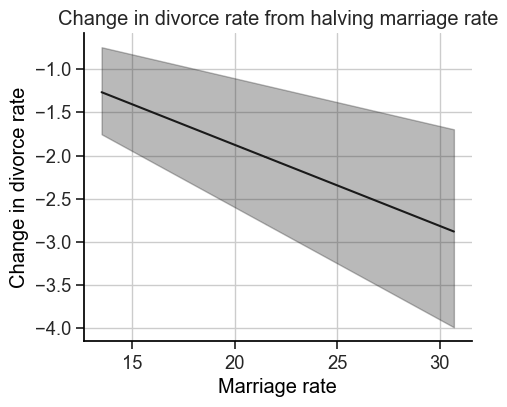

In [46]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(
    waffle.sort_values("Marriage")["Marriage"],
    waffle.sort_values("Marriage")["DivorceHalfMarriageChangeMean"],
    color="k",
)

ax.fill_between(
    waffle.sort_values("Marriage")["Marriage"],
    waffle.sort_values("Marriage")["DivorceHalfMarriageChangeLower"],
    waffle.sort_values("Marriage")["DivorceHalfMarriageChangeHigher"],
    color="k",
    alpha=0.3,
)

ax.set(
    xlabel="Marriage rate",
    ylabel="Change in divorce rate",
    title="Change in divorce rate from halving marriage rate",
);

Not that this is linear since divorce rate is modelled as a linear function of age which is modelled as a linear function of marriage rate.

Now we plot the expected divorce rate per state as an effect of halving the marriage rate.

In [47]:
waffle["DivorceHalfMarriageMean"] = (
    waffle["Divorce"] + waffle["DivorceHalfMarriageChangeMean"]
)
waffle["DivorceHalfMarriageLower"] = (
    waffle["Divorce"] + waffle["DivorceHalfMarriageChangeLower"]
)
waffle["DivorceHalfMarriageHigher"] = (
    waffle["Divorce"] + waffle["DivorceHalfMarriageChangeHigher"]
)

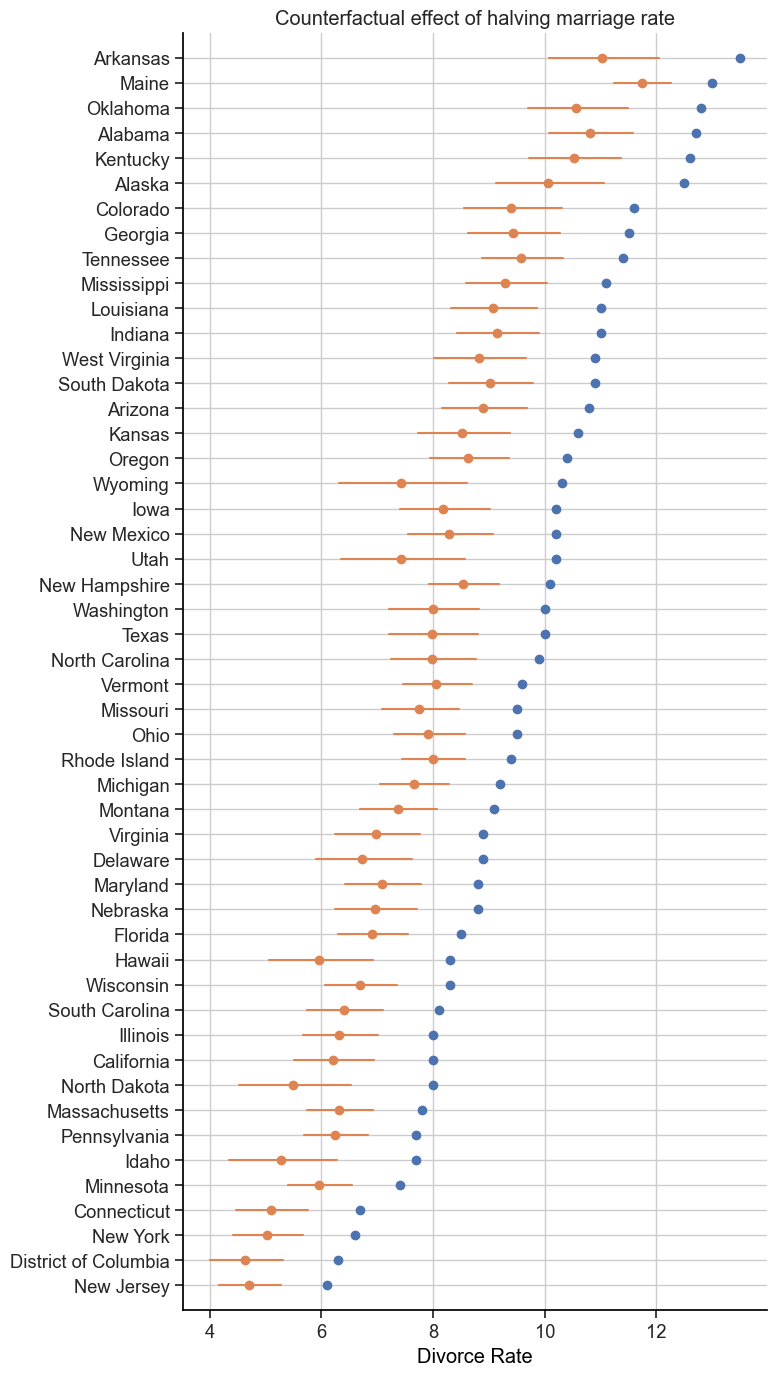

In [48]:
fig, ax = plt.subplots(figsize=(8, 14))

plot_data = waffle.sort_values("Divorce").reset_index(drop=True)
ax.scatter(
    plot_data.Divorce,
    plot_data.index,
    color=colors[0],
    label="Observed",
)

# plot actual divorce rates
ax.scatter(
    plot_data.DivorceHalfMarriageMean,
    plot_data.index,
    color=colors[1],
    label="Counterfactual",
)

# counterfactual divorce rates (mean)
ax.plot(
    plot_data[["DivorceHalfMarriageLower", "DivorceHalfMarriageHigher"]].T,
    [
        plot_data.index,
        plot_data.index,
    ],
    color=colors[1],
)

# counterfactual divorce rates (HDI)
ax.set(
    xlabel="Divorce Rate",
    yticks=range(plot_data.shape[0]),
    yticklabels=plot_data.Location,
    title="Counterfactual effect of halving marriage rate",
    ylim=[-1, 50],
)
fig.tight_layout();

### 5H3

Return to the milk energy model, `m5.7`.
Suppose that the true causal relationship among the variables is:

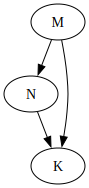

In [49]:
g = gr.Digraph()
g.edge("M", "N")
g.edge("M", "K")
g.edge("N", "K")
g

Now compute the counterfactual effect on $K$ of doubling $M$.
You will need to account for both the direct and indirect paths of causation.
Use the counterfactual example from the chapter (starting on page 140) as a template.

---

In [50]:
# load data
milk = load_data(MILK_FILE, delimiter=";")

# get log mass
milk["log_mass"] = np.log(milk["mass"])

# rename variables
milk = milk.rename(
    columns={
        "kcal.per.g": "kcal_per_g",
        "neocortex.perc": "neocortex_perc",
    }
)

# standardise variables
feature_cols_norm_mapper = {"kcal_per_g": "K", "neocortex_perc": "N", "log_mass": "M"}
feature_cols = list(feature_cols_norm_mapper.keys())
normed_feature_cols = list(feature_cols_norm_mapper.values())

milk_normaliser = StandardScaler().set_output(transform="pandas")
milk[normed_feature_cols] = milk_normaliser.fit_transform(milk[feature_cols])

# drop missing values
milk = milk.dropna()

In [51]:
coords = {"species": milk.species, "K_feature": ["M", "N"]}
with pm.Model(coords=coords) as m_5h3:
    # data
    M = pm.MutableData("M", milk.M, dims="species")

    # priors for model M -> N
    alpha_N = pm.Normal("alpha_N", mu=0, sigma=0.2)
    beta_N = pm.Normal("beta_N", mu=0, sigma=0.5)
    sigma_N = pm.Exponential("sigma_N", lam=1)

    # model
    mu_N = pm.Deterministic("mu_N", alpha_N + beta_N * M, dims="species")

    # likelihood
    N = pm.Normal("N", mu=mu_N, sigma=sigma_N, observed=milk.N, dims="species")

    # priors for M -> K <- N
    alpha_K = pm.Normal("alpha_K", mu=0, sigma=0.2)
    beta_K = pm.Normal("beta_K", mu=0, sigma=0.5, dims="K_feature")
    sigma_K = pm.Exponential("sigma_K", lam=1)

    # model
    mu_K = pm.Deterministic(
        "mu_K", alpha_K + beta_K[0] * M + beta_K[1] * N, dims="species"
    )

    # likelihood
    K = pm.Normal("K", mu=mu_K, sigma=sigma_K, observed=milk.K, dims="species")

    # press the inference button!
    trace_5h3 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_N, beta_N, sigma_N, alpha_K, beta_K, sigma_K]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


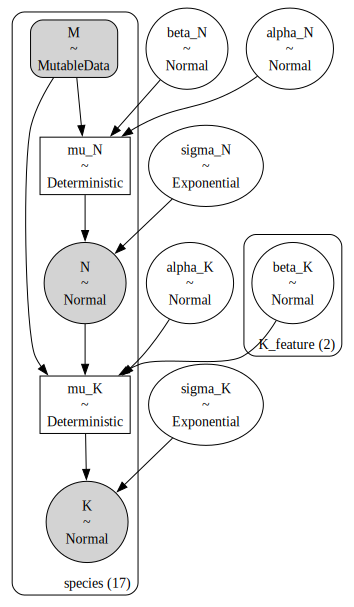

In [52]:
m_5h3.to_graphviz()

Take a look at the posteriors

In [53]:
az.summary(
    trace_5h3,
    var_names=["~mu"],
    filter_vars="regex",
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha_N,-0.01,0.13,-0.22,0.20
beta_N,0.61,0.15,0.35,0.84
alpha_K,0.06,0.15,-0.17,0.29
beta_K[M],-0.64,0.25,-1.03,-0.25
beta_K[N],0.60,0.27,0.17,1.03
sigma_N,0.74,0.14,0.53,0.95
sigma_K,0.89,0.18,0.60,1.14


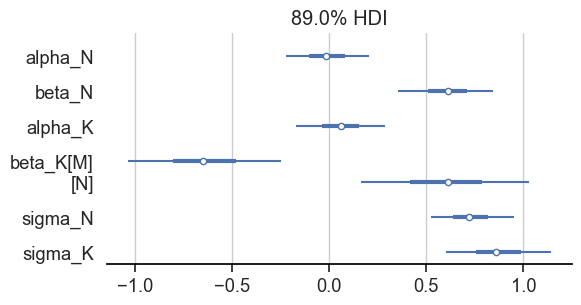

In [54]:
az.plot_forest(
    trace_5h3,
    var_names=["~mu"],
    filter_vars="regex",
    hdi_prob=0.89,
    combined=True,
    figsize=(6, 3),
);

Roughly this is saying that $N$ is positively correlated with $M$ and that $K$ is positively correlated with $N$, but negatively correlated with $M$.
So, if $M$ increases by $\delta$ then $N$ should increase by $0.6\delta$, and $K$ should increase by $(0.6)^2 \delta - (0.65) \delta \approx -0.3 \delta$.

Let's plot the posterior for the regression of $N$ on $M$ and the posterior predictive for the full model on $K$.

In [55]:
with m_5h3:
    trace_5h3 = pm.sample_posterior_predictive(
        trace_5h3,
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

Sampling: [K, N]


In [56]:
def plot_posterior_predictions(
    predictor_data,
    posterior_data,
    outcome_data=None,
    posterior_predictive_data=None,
    hdi_prob=0.89,
    ax=None,
):
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 4))

    # observed data
    if outcome_data is not None:
        sns.scatterplot(
            x=predictor_data,
            y=outcome_data,
            ax=ax,
        )

    # get data to plot posteriors
    posterior_name = posterior_data.name
    posterior_hdi = az.hdi(posterior_data, hdi_prob=hdi_prob)
    plot_data = pd.DataFrame(
        {
            "predictor": predictor_data,
            "mean": posterior_data.mean(dim=["chain", "draw"]),
            "hdi_lower": posterior_hdi[posterior_name].sel(hdi="lower"),
            "hdi_higher": posterior_hdi[posterior_name].sel(hdi="higher"),
        }
    )

    if posterior_predictive_data is not None:
        pp_name = posterior_predictive_data.name
        pp_hdi = az.hdi(posterior_predictive_data, hdi_prob=hdi_prob)
        plot_data["pp_hdi_lower"] = pp_hdi[pp_name].sel(hdi="lower")
        plot_data["pp_hdi_higher"] = pp_hdi[pp_name].sel(hdi="higher")

    plot_data.sort_values("predictor", inplace=True)

    # posterior mean
    ax.plot(
        plot_data["predictor"],
        plot_data["mean"],
        color="k",
    )

    # posterior hdi
    ax.fill_between(
        plot_data["predictor"],
        plot_data["hdi_lower"],
        plot_data["hdi_higher"],
        color="k",
        alpha=0.3,
    )

    if posterior_predictive_data is not None:
        ax.fill_between(
            plot_data["predictor"],
            plot_data["pp_hdi_lower"],
            plot_data["pp_hdi_higher"],
            color="k",
            alpha=0.1,
        )

    ax.set(title="Posterior predictions")

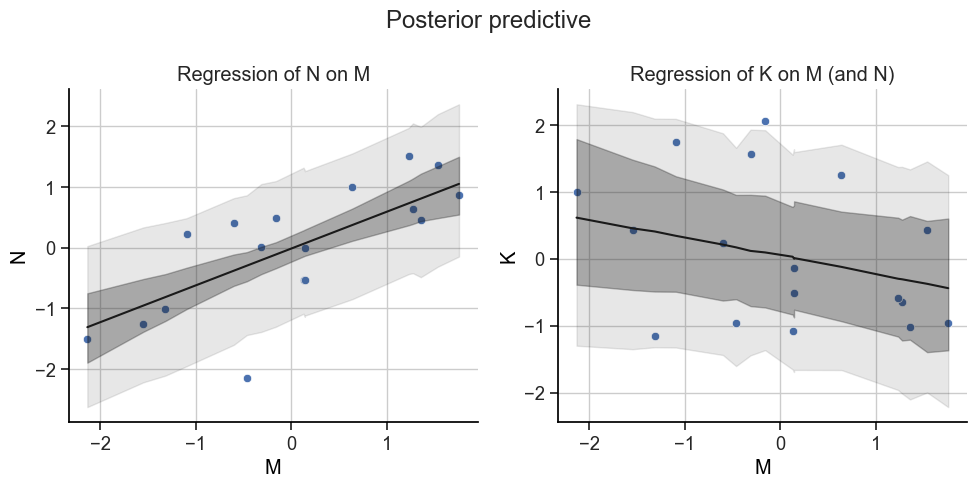

In [57]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

plot_posterior_predictions(
    trace_5h3.constant_data.M,
    trace_5h3.posterior.mu_N,
    outcome_data=trace_5h3.observed_data.N,
    posterior_predictive_data=trace_5h3.posterior_predictive.N,
    ax=axs[0],
)
axs[0].set_title("Regression of N on M")

plot_posterior_predictions(
    trace_5h3.constant_data.M,
    trace_5h3.posterior_predictive.mu_K,
    outcome_data=trace_5h3.observed_data.K,
    posterior_predictive_data=trace_5h3.posterior_predictive.K,
    ax=axs[1],
)
axs[1].set_title("Regression of K on M (and N)")

fig.suptitle("Posterior predictive")
fig.tight_layout();

Now let's estimate the counterfactuals.
The question asks for the counterfactual for doubling $M$, which is the standardised log mass.
This seems a little strange to me (by definition the mean of $M$ is zero so doubling it will have no effect), so I'll look at the counterfactual effect of doubling the actual mass instead. Due to properties of logarithms this is equivalent to adding `ln(2) / std(log_mass)` to $M$.

In [58]:
delta_M = milk_normaliser.var_[feature_cols.index("log_mass")]
print(delta_M)

2.783756093905696


Our back of the envelope estimate earlier suggests that this should roughly decrease $K$ by

In [59]:
print(round(delta_M * 0.3, 1))

0.8


I believe the effect of this should be constant (i.e. independent of that values of $M$ and $N$) but lets generate full counterfactuals for the data to be sure.

In [60]:
with m_5h3:
    pm.set_data({"M": milk.M + delta_M})
    trace_5h3 = pm.sample_posterior_predictive(
        trace_5h3,
        extend_inferencedata=True,
        predictions=True,
        random_seed=RANDOM_SEED,
    )

Sampling: [K, N]


Now look at the expected change

In [61]:
trace_5h3.predictions["K_counterfactual_change"] = (
    trace_5h3.predictions.K - trace_5h3.posterior_predictive.K
)

az.summary(
    trace_5h3,
    var_names="K_counterfactual_change",
    group="predictions",
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
K_counterfactual_change[Eulemur fulvus],-0.76,0.59,-1.74,0.11
K_counterfactual_change[Alouatta seniculus],-0.76,0.59,-1.74,0.11
K_counterfactual_change[A palliata],-0.76,0.59,-1.74,0.11
K_counterfactual_change[Cebus apella],-0.76,0.59,-1.74,0.11
K_counterfactual_change[S sciureus],-0.76,0.59,-1.74,0.11
K_counterfactual_change[Cebuella pygmaea],-0.76,0.59,-1.74,0.11
K_counterfactual_change[Callimico goeldii],-0.76,0.59,-1.74,0.11
K_counterfactual_change[Callithrix jacchus],-0.76,0.59,-1.74,0.11
K_counterfactual_change[Miopithecus talpoin],-0.76,0.59,-1.74,0.11
K_counterfactual_change[M mulatta],-0.76,0.59,-1.74,0.11


As expected, this has no dependence on the original values of $M$ and $N$.
Finally let's un-normalise:

In [62]:
K_idx = normed_feature_cols.index("K")
K_counterfactual_change = trace_5h3.predictions.K_counterfactual_change.isel(species=0)
kcal_per_g_counterfactual_change = K_counterfactual_change * milk_normaliser.mean_[
    K_idx
] + np.sqrt(milk_normaliser.var_[K_idx])
kcal_per_g_counterfactual_change.name = "kcal_per_g_counterfactual_change"

az.summary(kcal_per_g_counterfactual_change, kind="stats", hdi_prob=0.89, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
kcal_per_g_counterfactual_change,-0.33,0.38,-0.96,0.23


So we can answer the question simply: the counterfactual effect of doubling mass is an expected change in `kcal_per_g` of -0.33 with a 89% HDI of (-0.96, 0.23).

Note: this is actually a very wide interval - we expected that this would only actually decrease `kcal_per_g` 81% of the time.

### 5H4

Here is an open practice problem to engage your imagination.
In the divorce data, States in the southern United States have many of the highest divorce rates.
Add the South indicator variable to the analysis.
First, draw one or more DAGs that represent your ideas for how Southern American culture might influence any of the other three variables ($D$, $M$, or $A$).
Then list the testable implications of your DAGs, if there are any, and fit one or more models to evaluate the implications.
What do you think the influence of “Southerness” is?

---

Letting $S$ denote 'Southerness', I expect that this has a causal effect on both $M$ and $A$, but not $D$.
Combining this with the model from the book, this gives the following DAG:

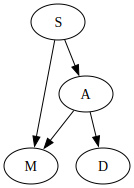

In [63]:
g = gr.Digraph()
g.edge("S", "A")
g.edge("S", "M")
g.edge("A", "M")
g.edge("A", "D")
g

The main testable implication of this DAG is that $S$ is conditionally independent of $D$ given $A$.

Let's start by reimporting the data.

In [64]:
# load data
waffle = load_data(WAFFLE_DIVORCE_FILE, delimiter=";")

# standardise variables
waffle_normaliser = StandardScaler().set_output(transform="pandas")
waffle[["divorce", "marriage", "age"]] = waffle_normaliser.fit_transform(
    waffle[["Divorce", "Marriage", "MedianAgeMarriage"]]
)
waffle.rename(columns={"South": "south"}, inplace=True)

waffle["north_south"] = np.where(
    waffle["south"] == 0,
    "north",
    "south",
)

Note that we already showed in the text that $D$ is conditionally independent of $M$ given $D$, so if we're only interested in $D$ then we can completely ignore $M$.
To test the implications of the DAG I'll first train a univariate model for $D$ on $A$ and compare this with a multivariate model on both $A$ and $S$.
I'm also going to widen the prior on $\beta$ a little - I think it's too tight.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


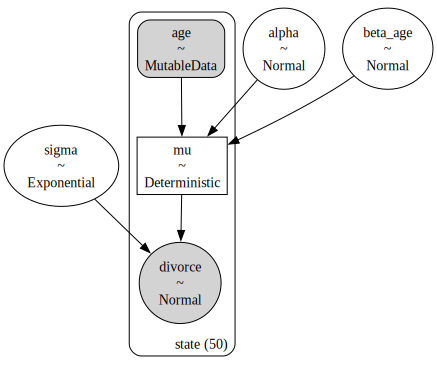

In [65]:
# A -> D
coords = {
    "state": waffle.Location,
}
with pm.Model(coords=coords) as m_5h4a:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_age = pm.Normal("beta_age", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # data
    age = pm.MutableData("age", waffle.age, dims="state")

    # linear model
    mu = pm.Deterministic("mu", alpha + beta_age * age, dims="state")

    # likelihood
    divorce = pm.Normal(
        "divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="state"
    )

    # inference button
    trace_5h4a = pm.sample(random_seed=RANDOM_SEED)


m_5h4a.to_graphviz()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


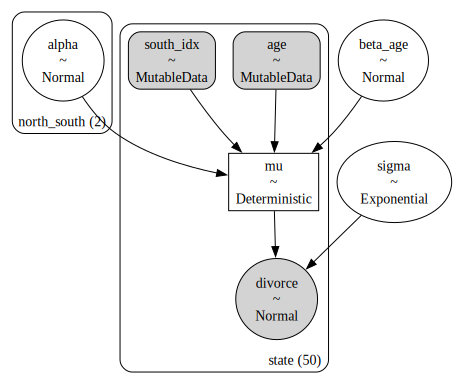

In [66]:
# A,S -> D
coords = {"state": waffle.Location, "north_south": ["north", "south"]}
with pm.Model(coords=coords) as m_5h4b:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2, dims="north_south")
    beta_age = pm.Normal("beta_age", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # data
    age = pm.MutableData("age", waffle.age, dims="state")
    south_idx = pm.MutableData("south_idx", waffle.south, dims="state")

    # linear model
    mu = pm.Deterministic("mu", alpha[south_idx] + beta_age * age, dims="state")

    # likelihood
    divorce = pm.Normal(
        "divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="state"
    )

    # inference button
    trace_5h4b = pm.sample(random_seed=RANDOM_SEED)


m_5h4b.to_graphviz()

Let's compare the predictions

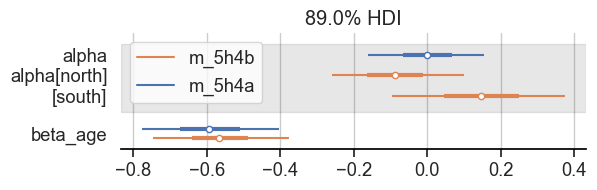

In [67]:
az.plot_forest(
    [trace_5h4a, trace_5h4b],
    model_names=["m_5h4a", "m_5h4b"],
    var_names=["alpha", "beta_age"],
    combined=True,
    hdi_prob=0.89,
    figsize=(6, 1.5),
);

I would say that this gives some support to the claim that $D$ is conditionally independent of $S$ given $A$ - the $\alpha$ values for the model that includes $S$ aren't very different from zero which lies in reasonal HDI.

To understand the models better I want to plot and compare the posterior predictions. For the model that includes $S$ I want to compare the regression lines for Northern and Southern states so I will generate counterfactual predictions for the states all being Northern and all being Southern.

In [68]:
def generate_north_south_counterfactual_predictions(model, trace, n_states=50):
    ns_traces = {}
    with model:
        pm.set_data(
            {
                "south_idx": np.zeros(50).astype(int),
            }
        )
        ns_traces["north"] = pm.sample_posterior_predictive(
            trace,
            var_names=["mu", "divorce"],
            random_seed=RANDOM_SEED,
        )

        pm.set_data(
            {
                "south_idx": np.ones(50).astype(int),
            }
        )
        ns_traces["south"] = pm.sample_posterior_predictive(
            trace,
            var_names=["mu", "divorce"],
            random_seed=RANDOM_SEED,
        )

    return ns_traces

In [69]:
ns_traces_5h4b = generate_north_south_counterfactual_predictions(m_5h4b, trace_5h4b)

Sampling: [divorce]


Sampling: [divorce]


In [70]:
def plot_posterior_mean_and_hdi(
    predictor_data, posterior_data, color="k", hdi_prob=0.89, ax=None
):
    if not ax:
        fig, ax = plt.subplots(figsize=(5, 4))

    posterior_name = posterior_data.name
    hdi = az.hdi(posterior_data, hdi_prob=0.89)
    plot_data = pd.DataFrame(
        {
            "predictor": predictor_data,
            "mean": posterior_data.mean(dim=["chain", "draw"]),
            "hdi_lower": hdi[posterior_name].sel(hdi="lower"),
            "hdi_higher": hdi[posterior_name].sel(hdi="higher"),
        }
    ).sort_values("predictor")

    ax.plot(
        plot_data["predictor"],
        plot_data["mean"],
        color=color,
    )

    ax.fill_between(
        plot_data["predictor"],
        plot_data["hdi_lower"],
        plot_data["hdi_higher"],
        color=color,
        alpha=0.3,
    )

In [71]:
def plot_divorce_model_with_and_without_southerness(
    waffle_data, univariate_trace, ns_traces, hdi_prob=0.89, ax=None
):
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 5))

    hue_order = ["north", "south"]
    sns.scatterplot(
        data=waffle_data,
        x="age",
        y="divorce",
        hue="north_south",
        hue_order=hue_order,
    )

    # plot univariate model
    plot_posterior_mean_and_hdi(waffle_data.age, univariate_trace.posterior.mu, ax=ax)

    # plot models with southernness
    for north_south, trace in ns_traces.items():
        color_idx = hue_order.index(north_south)
        color = colors[color_idx]
        plot_posterior_mean_and_hdi(
            waffle_data.age, trace.posterior_predictive.mu, color=color, ax=ax
        )

    ax.set(title="Posterior predictions with and without Southernness")
    ax.legend(title=None);

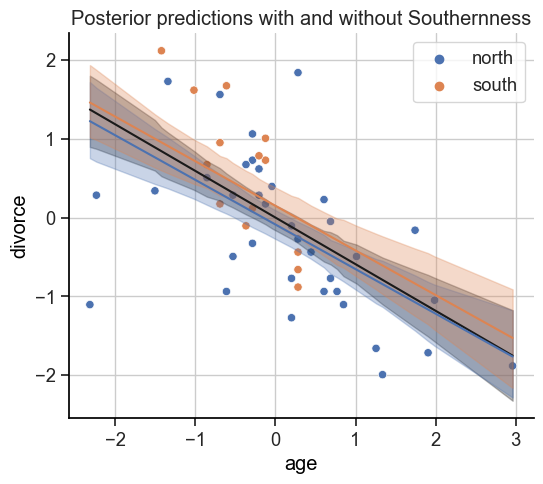

In [72]:
plot_divorce_model_with_and_without_southerness(waffle, trace_5h4a, ns_traces_5h4b)

You can see that including Southerness as a feature hasn't made much difference to the regression lines.
But, it also looks like the North/South regression lines don't fit that well.
This is probably because they are constrained to have the same slope.
Let's see if we can do better if we add an interaction term.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


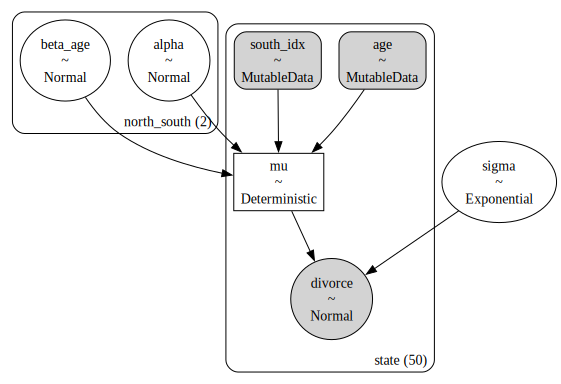

In [73]:
# with interaction term
coords = {"state": waffle.Location, "north_south": ["north", "south"]}
with pm.Model(coords=coords) as m_5h4c:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2, dims="north_south")
    beta_age = pm.Normal("beta_age", mu=0, sigma=1.5, dims="north_south")
    sigma = pm.Exponential("sigma", lam=1)

    # data
    age = pm.MutableData("age", waffle.age, dims="state")
    south_idx = pm.MutableData("south_idx", waffle.south, dims="state")

    # linear model
    mu = pm.Deterministic(
        "mu", alpha[south_idx] + beta_age[south_idx] * age, dims="state"
    )

    # likelihood
    divorce = pm.Normal(
        "divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="state"
    )

    # inference button
    trace_5h4c = pm.sample(random_seed=RANDOM_SEED)


m_5h4c.to_graphviz()

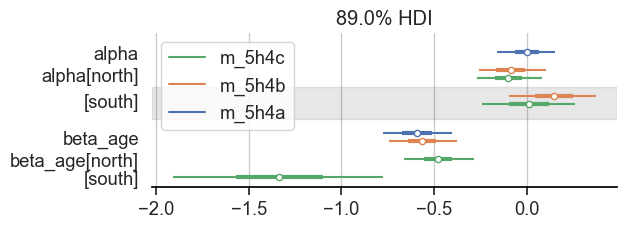

In [74]:
az.plot_forest(
    [trace_5h4a, trace_5h4b, trace_5h4c],
    model_names=["m_5h4a", "m_5h4b", "m_5h4c"],
    var_names=["alpha", "beta_age"],
    combined=True,
    hdi_prob=0.89,
    figsize=(6, 2),
);

This looks much better.
The Southern age slope is significantly different from either the Northern slope or the univariate model.

Let's plot the posterior predictions again

Sampling: [divorce]


Sampling: [divorce]


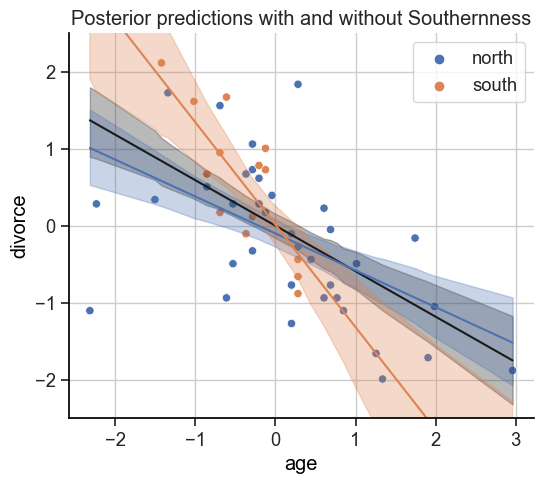

In [75]:
ns_traces_5h4c = generate_north_south_counterfactual_predictions(m_5h4c, trace_5h4c)
plot_divorce_model_with_and_without_southerness(waffle, trace_5h4a, ns_traces_5h4c)

ax = plt.gca()
ax.set(ylim=[-2.5, 2.5]);

That certainly looks a lot better and you can tell that Southerness has a strong impact on the slope.

It actually looks like there isn't much dependence of the intercept on Southerness.
For a final model I'll remove that term and just keep the interaction term.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


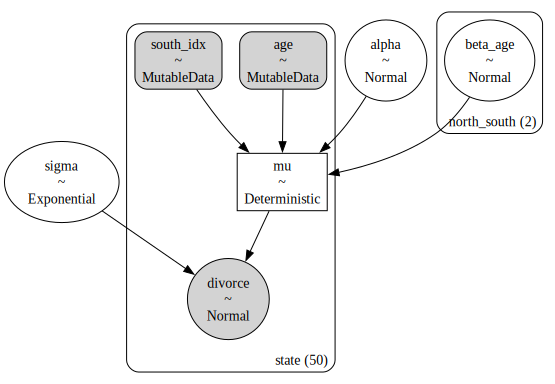

In [76]:
# with interaction term
coords = {"state": waffle.Location, "north_south": ["north", "south"]}
with pm.Model(coords=coords) as m_5h4d:
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_age = pm.Normal("beta_age", mu=0, sigma=1.5, dims="north_south")
    sigma = pm.Exponential("sigma", lam=1)

    # data
    age = pm.MutableData("age", waffle.age, dims="state")
    south_idx = pm.MutableData("south_idx", waffle.south, dims="state")

    # linear model
    mu = pm.Deterministic("mu", alpha + beta_age[south_idx] * age, dims="state")

    # likelihood
    divorce = pm.Normal(
        "divorce", mu=mu, sigma=sigma, observed=waffle.divorce, dims="state"
    )

    # inference button
    trace_5h4d = pm.sample(random_seed=RANDOM_SEED)


m_5h4d.to_graphviz()

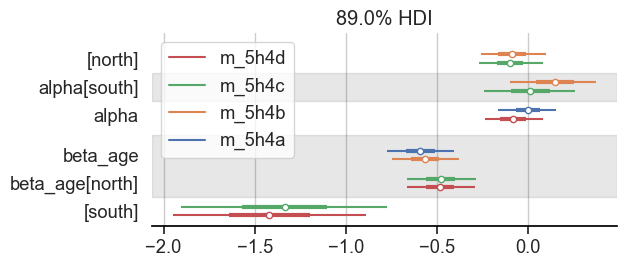

In [77]:
az.plot_forest(
    [trace_5h4a, trace_5h4b, trace_5h4c, trace_5h4d],
    model_names=["m_5h4a", "m_5h4b", "m_5h4c", "m_5h4d"],
    var_names=["alpha", "beta_age"],
    combined=True,
    hdi_prob=0.89,
    figsize=(6, 2.5),
);

This hasn't really made much difference to the slope values.

Sampling: [divorce]


Sampling: [divorce]


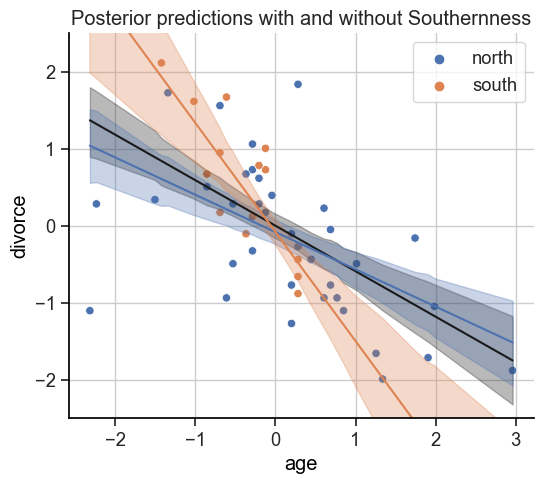

In [78]:
ns_traces_5h4d = generate_north_south_counterfactual_predictions(m_5h4d, trace_5h4d)
plot_divorce_model_with_and_without_southerness(waffle, trace_5h4a, ns_traces_5h4d)

ax = plt.gca()
ax.set(ylim=[-2.5, 2.5]);

I think this looks like a really good fit.
The only improvement I can see is that the variance around the regression line for Southern states looks less than for the Northern states.

The conclusion is that our DAG was incorrect: there is a strong dependence of divorce rate on Southerness even accounting for age.
More precisely, divorce rate decreases with median marriage age and this decrease is much stronger in Southern states.
That is, Southern states where people marry young have much higher divorce rates than such Northern states.